In [5]:
# imports
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from VAN import *


Différentes distributions de probabilité pour des spins de taille 6

In [2]:
taille=6
## différentes distributions de probabilité

def p(s): # seuls deux spins ont une proba non nulle
    if torch.eq(s, torch.tensor([1.0 for i in range(taille//2)] + [0.0 for i in range(taille//2)])).all().item():
        return 0.499
    elif torch.eq(s, torch.tensor([0.0 for i in range(taille//2)] + [1.0 for i in range(taille//2)])).all().item():
        return 0.499
    else:
        
        return 1e-8
    
def uniforme(s): 
    return 1/(2**taille)

def p3(s): # deux spins ont une proba non nulle et l'un prévaut sur l'autre
    if torch.eq(s, torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0])).all().item():
        return 0.75
    elif torch.eq(s, torch.tensor([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])).all().item():
        return 0.25
    else:
        return 0.001


def p1(s): # seuls deux spins ont une proba non nulle
    if  torch.eq(s, torch.tensor([0.0, 0.0, 0.0, 1.0, 1.0, 1.0 ])).all().item() :
        return 0.499
    elif    torch.eq(s, torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0])).all().item()   :
        return 0.499
    else:
        
        return 0.00001

def p2(s):
    if s[0]==1.0:
        return 1/(2**(taille-1))
    else:
        return 1e-30
    
    
def energie1D(spin): 
    spin_copie=spin.clone()
    spin_copie[spin_copie==0]=-1
    spin_copie_1 = torch.roll(spin_copie, -1)
    spin_copie_2 = torch.roll(spin_copie, 1)
    energie=- torch.sum(spin_copie_1*spin_copie+spin_copie_2*spin_copie)
    return energie
    

def distrib_energie(spin):
    energie=energie1D(spin)
    return torch.exp(-energie)
    

**Test des différents modèles**

Modèle 1 : tous les spins ont une proba non nulle sauf deux:

Epoch 0: 6.9152069091796875
Epoch 100: 3.086731195449829
Epoch 200: 0.7640000581741333
Epoch 300: 0.41422024369239807
Epoch 400: 0.16290128231048584
Epoch 500: 0.1845211386680603
Epoch 600: 0.10768300294876099
Epoch 700: 0.06507889181375504
Epoch 800: 0.09077712893486023
Epoch 900: 0.06483817845582962


Text(0.5, 1.0, 'Entraînement modèle premier spin')

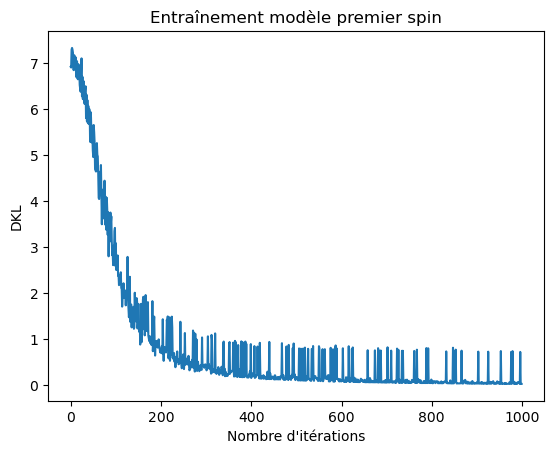

In [34]:
mymodel=VAN(taille, torch.sigmoid)

l=train(mymodel, p1, n_iter=1000, lr=1e-2, train_size=50)

plt.plot(l)
plt.xlabel('Nombre d\'itérations')

plt.ylabel('DKL')
plt.title('Entraînement modèle premier spin')

Test du modèle 1

In [35]:

y3=torch.tensor([0.0 for i in range(taille)])
y4=torch.tensor([1.0 for i in range(taille)])


y1=torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0])
y2= torch.tensor([0.0, 0.0, 0.0, 1.0, 1.0, 1.0 ])

In [36]:
print(calculer_proba(y1, mymodel))
print(calculer_proba(y2, mymodel))
print(calculer_proba(y3, mymodel))
print(calculer_proba(y4, mymodel))

0.9686437399552487
2.2732775462849995e-05
6.39679350108338e-05
6.442428805606764e-07


In [31]:
mymodel(y1).detach().numpy()[1:6]

array([0.9252636 , 0.96222466, 0.02227388, 0.02295743, 0.02343702],
      dtype=float32)

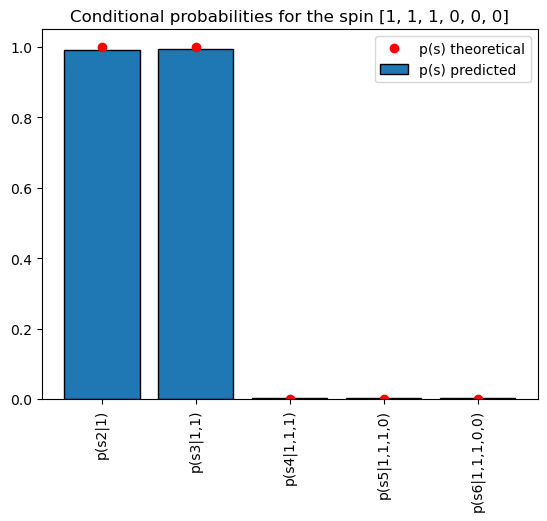

In [37]:
plt.bar(np.array([ 'p(s2|1)', 'p(s3|1,1)', 'p(s4|1,1,1)', 'p(s5|1,1,1,0)', 'p(s6|1,1,1,0,0)']) , mymodel(y1).detach().numpy()[1:6], label='p(s) predicted', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Conditional probabilities for the spin [1, 1, 1, 0, 0, 0]')
# superposer le graphe théorique
plt.plot(np.array([ 'p(s2|1)', 'p(s3|1,1)', 'p(s4|1,1,1)', 'p(s5|1,1,1,0)', 'p(s6|1,1,1,0,0)']) , [ 1, 1, 0, 0, 0], 'o',  label='p(s) theoretical', color='red')
plt.legend()
plt.show()

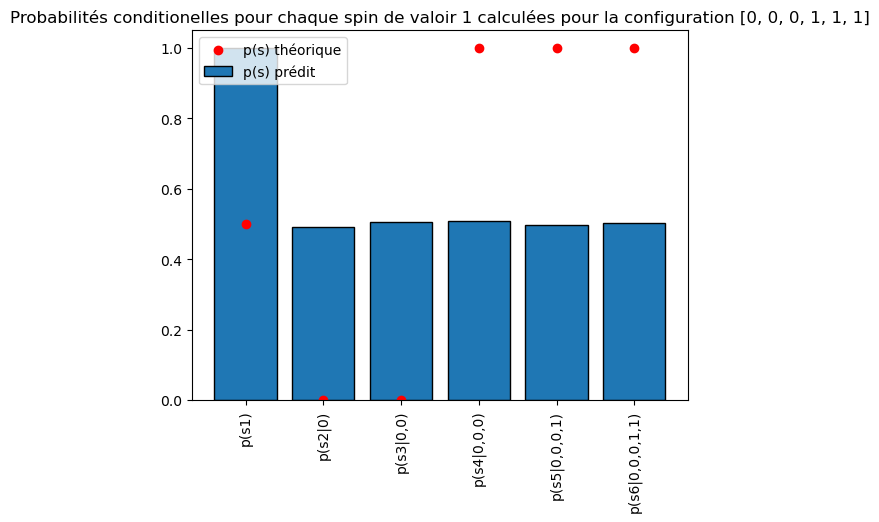

In [7]:
#idem pour y4
plt.bar(np.array(['p(s1)', 'p(s2|0)', 'p(s3|0,0)', 'p(s4|0,0,0)', 'p(s5|0,0,0,1)', 'p(s6|0,0,0,1,1)']) , mymodel(y4).detach().numpy(), label='p(s) prédit', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Probabilités conditionelles pour chaque spin de valoir 1 calculées pour la configuration [0, 0, 0, 1, 1, 1]')
# superposer le graphe théorique
plt.plot(np.array(['p(s1)', 'p(s2|0)', 'p(s3|0,0)', 'p(s4|0,0,0)', 'p(s5|0,0,0,1)', 'p(s6|0,0,0,1,1)']) , [0.5, 0, 0, 1, 1, 1], 'o',  label='p(s) théorique', color='red')
plt.legend()
plt.show()


Calcul des probas totales:


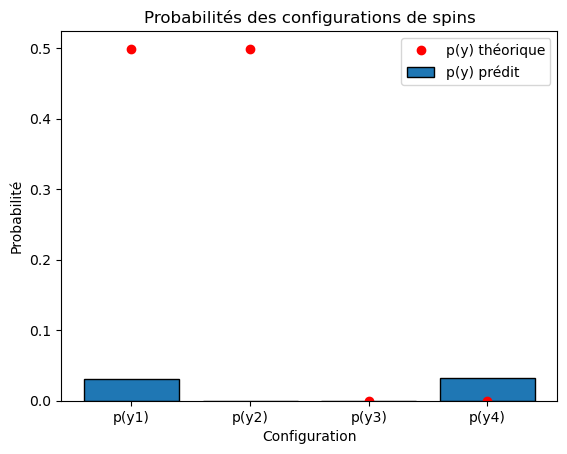

In [8]:
py1=calculer_proba(y1, mymodel)
py2=calculer_proba(y2, mymodel)
py3=calculer_proba(y3, mymodel)
py4=calculer_proba(y4, mymodel)
plt.bar(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [py1, py2, py3, py4], edgecolor='black', label='p(y) prédit')
plt.plot(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [p(y1), p(y2), p(y3), p(y4)], 'o', label='p(y) théorique', color='red')
plt.title('Probabilités des configurations de spins')
plt.xlabel('Configuration')
plt.ylabel('Probabilité')
plt.legend()
plt.show()


Second modèle: loi uniforme

Epoch 0: 1.0
Epoch 20: 1.0000150203704834
Epoch 40: 1.0000007152557373
Epoch 60: 1.0
Epoch 80: 0.9999999403953552
Epoch 100: 1.0
Epoch 120: 1.0
Epoch 140: 0.9999999403953552
Epoch 160: 1.0
Epoch 180: 1.0


Text(0.5, 1.0, 'Entraînement modèle uniforme')

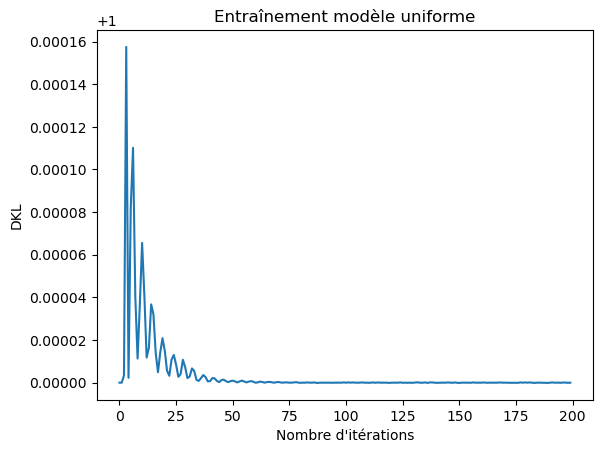

In [9]:
model_uniforme=VAN(6, torch.sigmoid)
l=train(model_uniforme, uniforme, n_iter=200, lr=1e-2, train_size=100)


plt.plot(l)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle uniforme')

Cela marche très bien pour l'uniforme car on initialise le VAN pour qu'il ressorte une loi uniforme

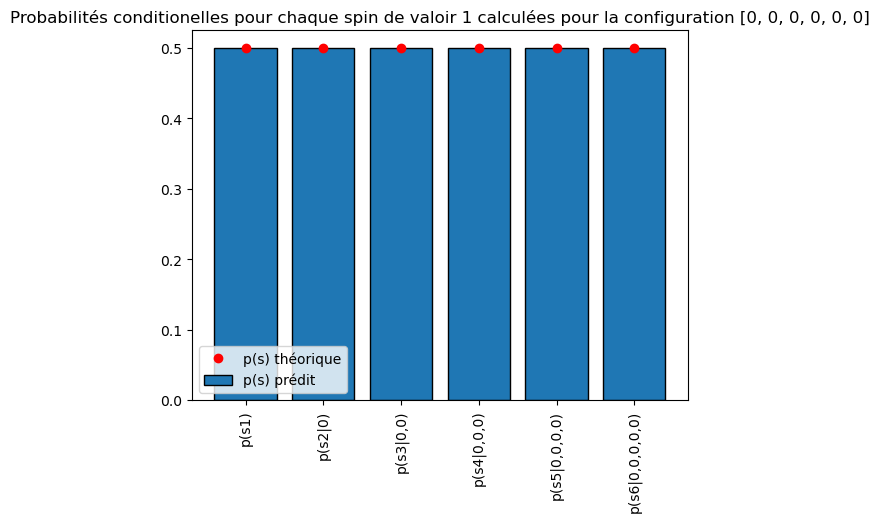

In [10]:
plt.bar(np.array(['p(s1)', 'p(s2|0)', 'p(s3|0,0)', 'p(s4|0,0,0)', 'p(s5|0,0,0,0)', 'p(s6|0,0,0,0,0)']) , model_uniforme(y2).detach().numpy(), label='p(s) prédit', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Probabilités conditionelles pour chaque spin de valoir 1 calculées pour la configuration [0, 0, 0, 0, 0, 0]')
# superposer le graphe théorique
plt.plot(np.array(['p(s1)', 'p(s2|0)', 'p(s3|0,0)', 'p(s4|0,0,0)', 'p(s5|0,0,0,0)', 'p(s6|0,0,0,0,0)']) , [0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'o',  label='p(s) théorique', color='red')
plt.legend()
plt.show()


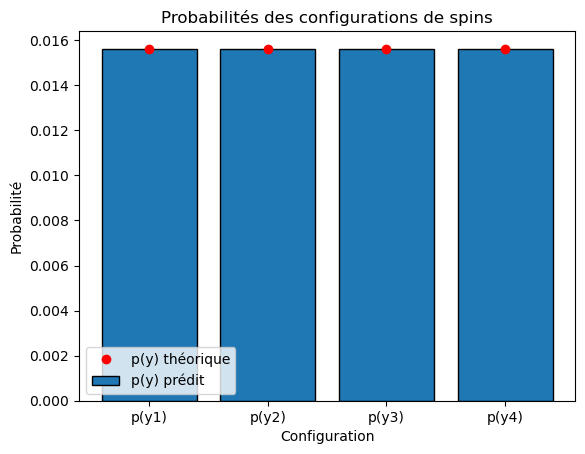

In [11]:
py1=calculer_proba(y1, model_uniforme)
py2=calculer_proba(y2, model_uniforme)
py3=calculer_proba(y3, model_uniforme)
py4=calculer_proba(y4, model_uniforme)
plt.bar(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [py1, py2, py3, py4], edgecolor='black', label='p(y) prédit')
plt.plot(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [uniforme(y1), uniforme(y2), uniforme(y3), uniforme(y4)], 'o', label='p(y) théorique', color='red')
plt.title('Probabilités des configurations de spins')
plt.xlabel('Configuration')
plt.ylabel('Probabilité')
plt.legend()
plt.show()

Troisième modèle : 

Epoch 0: 16.211124420166016
Epoch 20: 1.392134428024292
Epoch 40: 1.3942636251449585
Epoch 60: 1.3587675094604492
Epoch 80: 1.3513950109481812
Epoch 100: 1.3723376989364624
Epoch 120: 1.3408429622650146
Epoch 140: 1.3512212038040161
Epoch 160: 1.3466163873672485
Epoch 180: 1.3461027145385742


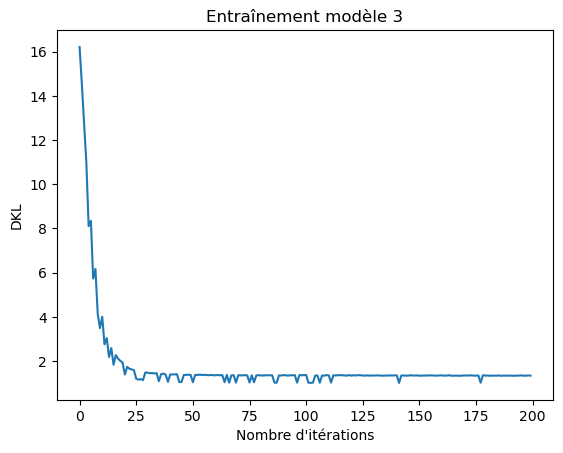

In [12]:
model3=VAN(6, torch.sigmoid)
l=train(model3, p3, n_iter=200, lr=1e-1, train_size=100)
plt.plot(l)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle 3')
plt.show()

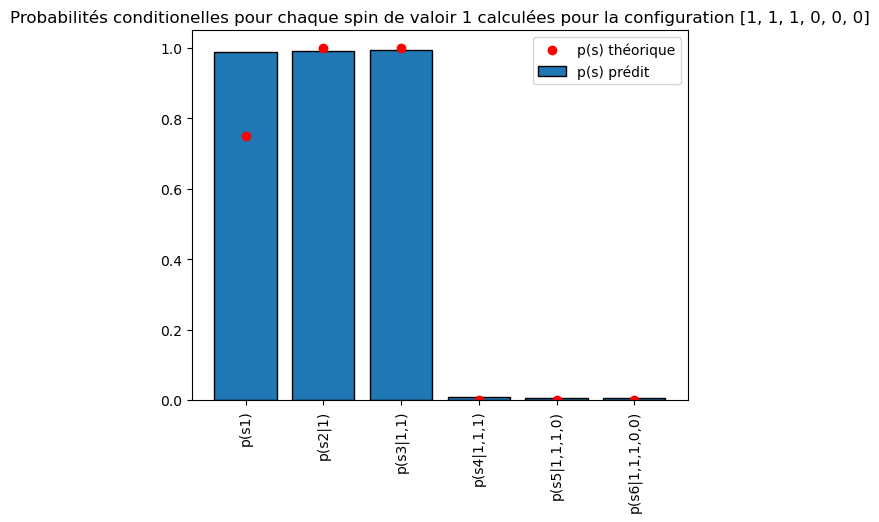

In [13]:
plt.bar(np.array(['p(s1)', 'p(s2|1)', 'p(s3|1,1)', 'p(s4|1,1,1)', 'p(s5|1,1,1,0)', 'p(s6|1,1,1,0,0)']) , model3(y1).detach().numpy(), label='p(s) prédit', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Probabilités conditionelles pour chaque spin de valoir 1 calculées pour la configuration [1, 1, 1, 0, 0, 0]')
# superposer le graphe théorique
plt.plot(np.array(['p(s1)', 'p(s2|1)', 'p(s3|1,1)', 'p(s4|1,1,1)', 'p(s5|1,1,1,0)', 'p(s6|1,1,1,0,0)']) , [0.75, 1, 1, 0, 0, 0], 'o',  label='p(s) théorique', color='red')
plt.legend()
plt.show()

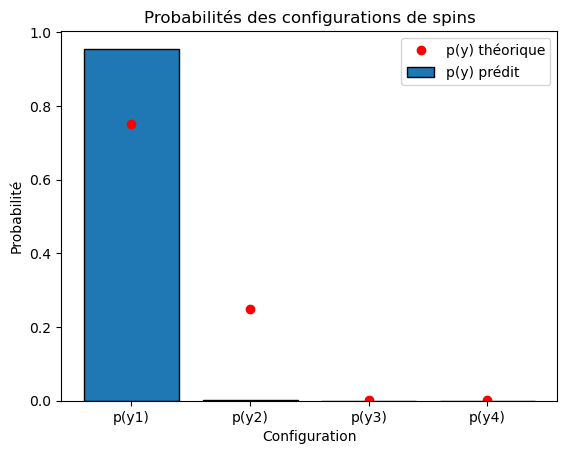

In [14]:
# probabilités totales:
py1=calculer_proba(y1, model3)
py2=calculer_proba(y2, model3)
py3=calculer_proba(y3, model3)
py4=calculer_proba(y4, model3)
plt.bar(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [py1, py2, py3, py4], edgecolor='black', label='p(y) prédit')
plt.plot(['p(y1)', 'p(y2)', 'p(y3)', 'p(y4)'], [p3(y1), p3(y2), p3(y3), p3(y4)], 'o', label='p(y) théorique', color='red')
plt.title('Probabilités des configurations de spins')
plt.xlabel('Configuration')
plt.ylabel('Probabilité')
plt.legend()
plt.show()

Epoch 0: 0.6580082774162292
Epoch 20: -1.566376805305481
Epoch 40: -0.5073603391647339
Epoch 60: 0.014171047136187553
Epoch 80: -0.36409011483192444
Epoch 100: -0.17592668533325195
Epoch 120: -0.048706308007240295
Epoch 140: 0.1366427093744278
Epoch 160: -0.14371147751808167
Epoch 180: -0.6023682355880737


Text(0.5, 1.0, 'Entraînement modèle 1')

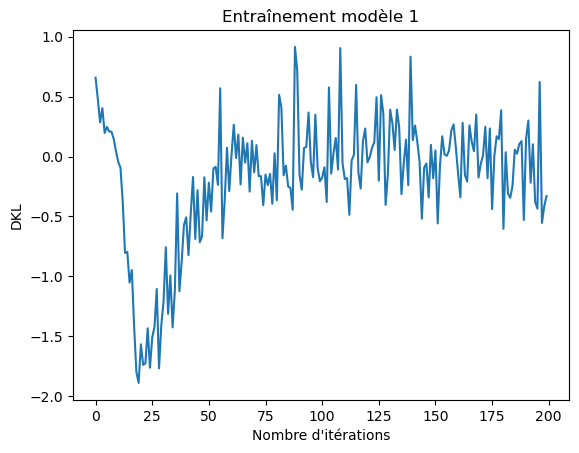

In [15]:
#test prof 


def log_p(spins):
    return torch.tensor([torch.log(torch.tensor(p3(spin)) ) for spin in spins])
from VAN_new import *
import matplotlib.pyplot as plt
taille=6
mymodel=VAN(taille, torch.sigmoid)

l=train(mymodel,log_p,  n_iter=200, lr=1e-1)

plt.plot(l)
plt.xlabel('Nombre d\'itérations')
plt.ylabel('DKL')
plt.title('Entraînement modèle 1')